# Univariate Time Series Forecasting
The workbook demonstrates forecasting time series values using a single value (_Univariate_).

By now you should be familiar with foundation networks such as Dense, CNNs and LSTMs and we will use these in this workbook to forecast the next value in the sequence.

The dataset we will be used contains two variables but for the time being we will only use one of these.

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [79]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
print(tf.__version__)

import numpy as np

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

2.0.0-beta1


## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [124]:
# Useful functions
def print_timeseries(generator, num_samples=0):
    pairs = len(generator[0][0])
    if (num_samples > 0 and num_samples < pairs ):
        pairs = num_samples
    
    for i in range(pairs):
        x = generator[0][0][i]
        
        y = generator[0][1][i]
        
        print("[%s] => [%s]" % (x, y))

def create_target_series_for_generator(data, skip_output=0, output_length=1):
    # The Generator will deal selecting the next in the sequence
    # but if our predictions are skiping steps we need to shift our data a bit
    shifted_data = data[skip_output:]
   
    # Now we loop through this shifted data set and collect sucessive  pairs
    # and add them to our target_seq
    target_seq = []
    # Stop before we run out of output groups
    pairs = len(shifted_data) - output_length
    for i in range(pairs):
        item = []
        for j in range(output_length):
            item.append(shifted_data[i+j])
        target_seq.append(item)
    return target_seq

def printLoss(history):
    history_dict = history.history
    loss = history_dict['loss']
    epochs = range(1, len(loss) + 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def get_y_from_generator(generator):
    y = None
    for i in range(len(generator)):
        batch_y = generator[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    
    return y

## Get the data
The data we are using contains monthly figures for the number of Passengers (in thousands) and the Mean Monthly Temperature for the associated Month.

For this workbook we will only be working with the number of Passengers

In [53]:
# Import some sample data
dataset = pandas.read_csv('passengers_and_temps.csv',  engine='python')
dataset.head()

timeseries_data = np.array(dataset['Passengers'].values)

### Plotting the data
The following cell plots a graph showing the number of Passengers travelling per month over a 12 year period.

You can see from the graph that the data shows:
- A general upward trend with each each of data being higher than the last
- A seasonality to the data where each year has a similar shape but differs in the ranges of values

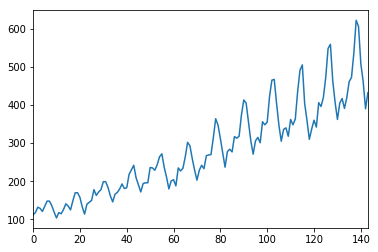

In [52]:
dataset['Passengers'].plot()

## Prepare our data
We now need to prepare our data and create a TimeseriesGenerator to work with. 

In this workbook we are only looking to predict the passenger levels for the next month given the previous few months of data.

### Normalise our data
As before we need to normalise our data so that our values are in the range 0-1 to help learning

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries_data = scaler.fit_transform(timeseries_data.reshape(-1,1))

C:\Users\Bill\Anaconda3\envs\ai\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


We will use TimeseriesGenerators but before we create them we need to split our data into Training and Testing sets.

### Exercise
Look at the graph above, at what point should we make the split?

If you rememebr from the previous workbook we want our Testing set to contain any Seasonality and Trends present in our Training data. Additionally, we usually take Testing data from the most recent data.

Set the value below to make the split - this is in months so a value between 1 and 144 is needed.

In [83]:
testing_data_after = 120

train_data = timeseries_data[:testing_data_after]
test_data = timeseries_data[testing_data_after:]


Next we need to create our TimeseriesGenerators for training and testing. In this workbook we are only predicing the next month ahead but we need to decide on how many historical months we will use to forecast ahead

### Exercise
How many months of data should we use as our features? 1 month, 3 months, 6 months? Some other value?

In the next cell you can specify the number of months to use as features in your model.

In [102]:
# TODO: Specify the number of months you want to use as your features
feature_months = 6

# Create our TimeseriesGenerator for Training
training_generator = TimeseriesGenerator (data = train_data,
                                    targets = train_data,
                                    length = feature_months)

# Create our TimeseriesGenerator for Testing
testing_generator = TimeseriesGenerator (data = test_data,
                                    targets = test_data,
                                    length = feature_months)

# Print out the start of our original series
print(train_data[:5])
print("\n")

# print out a sample of our training data to check our generators are correct
print_timeseries(training_generator, 1)

[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


[[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]]] => [[0.08494208]]


# Build our Model
We are now in a position to design our model using your own choice of networks architecture. We will provide a skeleton for you but it will be up to you to complete the model and train it.

## Exercise
Work in your groups to decide what network archiecture you will use and each train a different network to compare the results.

Some options include:
 - Create a network consisting of a series of Dense layers
 - Create a network using a series of CNN layers
 - Create a network using an LSTM

We have provided you with starter code for each of the 3 options. You should complete the cell for the model you are building and only run that cell. 

Each Cell has been set to be a _Markup_ cell so you will need to change the cell type on the one you are building to be _Code_. 

Ask if you are not sure how to do this

In [97]:
# Multi-Level Network using Dense Nodes

model = tf.keras.Sequential()

# Input Layer
model.add(keras.layers.Input(shape=(feature_months, 1)))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Flatten())

# Hidden Layers
# TODO: Add one or more hidden layers
model.add(keras.layers.Dense(units=128, activation='relu'))


# Output Layer
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer='adam')

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 3, 128)            256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               49280     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 82,689
Trainable params: 82,689
Non-trainable params: 0
__________________________________________________

In [139]:
# CNN Network
model = keras.Sequential()

# Input Layer
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', 
                     input_shape=[feature_months, 1]))
model.add(keras.layers.MaxPooling1D(pool_size=2))

# Hidden Layers
model.add(keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))



# Output Layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer='adam')

model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 6, 64)             192       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3, 128)            16512     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

In [121]:
# LSTM Network
model = tf.keras.models.Sequential()

model.add(keras.layers.LSTM(units = feature_months*2, input_shape=(feature_months, 1)))

# TODO: Optionally add one or more Dense layers
model.add(keras.layers.Dense(128))

# Output layer
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12)                672       
_________________________________________________________________
dense_31 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


# Train your model

In [140]:
# We'll train for some epochs
max_epochs = 100

# Stop early if our Validation Loss stagnates
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# Train our model
history = model.fit_generator(training_generator, epochs = max_epochs,
                   callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 1s 871ms/step - loss: 0.1066
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0886
Epoch 3/100
1/1 [==============================] - 0s 79ms/step - loss: 0.0757
Epoch 4/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0647
Epoch 5/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0542
Epoch 6/100
1/1 [==============================] - 0s 106ms/step - loss: 0.0445
Epoch 7/100
1/1 [==============================] - 0s 111ms/step - loss: 0.0356
Epoch 8/100
1/1 [==============================] - 0s 104ms/step - loss: 0.0275
Epoch 9/100
1/1 [==============================] - 0s 119ms/step - loss: 0.0206
Epoch 10/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0152
Epoch 11/100
1/1 [==============================] - 0s 100ms/step - loss: 0.0113
Epoch 12/100
1/1 [==============================] - 0s 100ms/step - loss: 0.0093
Epoch 13/100
1/1 [=======================

# Evaluate your model
With the model trained we can evaluate the model against our training data.

__Note__: We only have 144 data points so our models are probably not going to be that accurate.

## Exercise
Look at the plot of the model loss during training; if the curve has shallowed out and not changing much then the model has probably reached it's limit of learning. If not continue to train the model for more epochs.


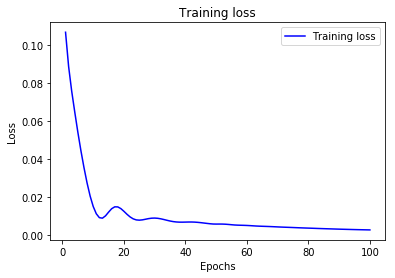

In [141]:
printLoss(history)

## Exercise
We can now run our model against the previously unseen error and get a measure of how good the model is (Mean Squared Error). 

While this may look small we have to remember that we normalised the data to the range 0-1

In [142]:
# Evaluate
model.evaluate_generator(testing_generator)

0.010265066288411617

# Comparing Predicted and Actual forecast
Let's now plot our predicted values against the actual values.

Before we can do this we need to extract some values from our testing generator

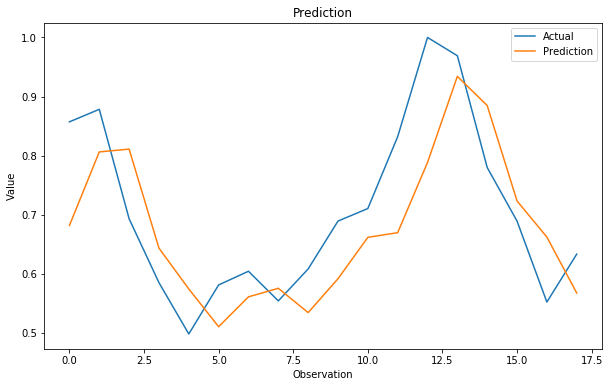

In [144]:
# Make predictions
y_pred_test = model.predict(testing_generator)
y_actual = get_y_from_generator(testing_generator)


# Plot graph of predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred_test, label='Prediction')
plt.title("Prediction")
plt.xlabel('Observation')
plt.ylabel('Value')
plt.legend()
plt.show();